In [1]:
import torch
import torchvision
print(torch.__version__)
print(torch.cuda.get_device_name(0))



2.5.1
NVIDIA GeForce RTX 3080


In [2]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100
input_size = 28 * 28
output_size = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [3]:

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.5,), (0.5,))
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.5,), (0.5,))
                               ])),
    batch_size=batch_size_test, shuffle=True)


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape


torch.Size([1000, 1, 28, 28])

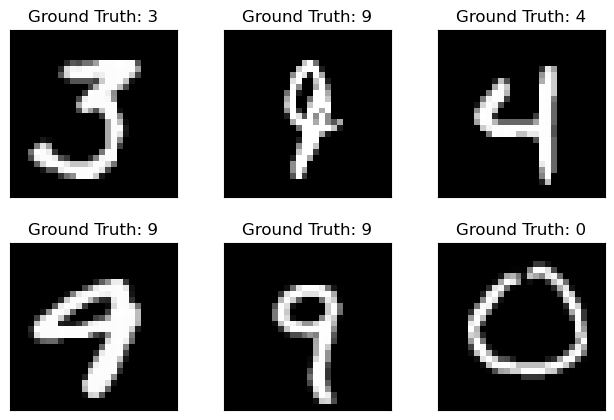

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
device = torch.device("cuda")

In [9]:
class FCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 20)  # First hidden layer with 16 nodes
        self.fc2 = nn.Linear(20, 20)         # Second hidden layer with 16 nodes
        self.fc3 = nn.Linear(20, output_size)  # Output layer for classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU after first hidden layer
        x = torch.relu(self.fc2(x))  # ReLU after second hidden layer
        x = self.fc3(x)  # Output layer
        return x

In [10]:
# Initialize the model, loss, and optimizer
model = FCNN(input_size, output_size)
model = model.to(device)
criterion = nn.CrossEntropyLoss()  # Loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    data = data.view(-1, 28*28)
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'results/fcnnModel.pth')
      torch.save(optimizer.state_dict(), 'results/fcnnOptimizer.pth')

In [13]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data = data.view(-1, 28*28)
      output: torch.Tensor = model(data)

      _, predicted = torch.max(output, 1)
      correct += predicted.eq(target.data.view_as(predicted)).sum()
      test_loss += criterion(output, target).item()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()



Test set: Avg. loss: 0.0023, Accuracy: 984/10000 (10%)



In [15]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327109
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.960739
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.262177
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.873196
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.737246
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.423200
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.553184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.372461
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.293493
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.610947

Test set: Avg. loss: 0.0004, Accuracy: 8738/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.479460
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.642224
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.636211
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.543140
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.482299
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.370055
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.406114
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.822042
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.197130
Trai

([], [])

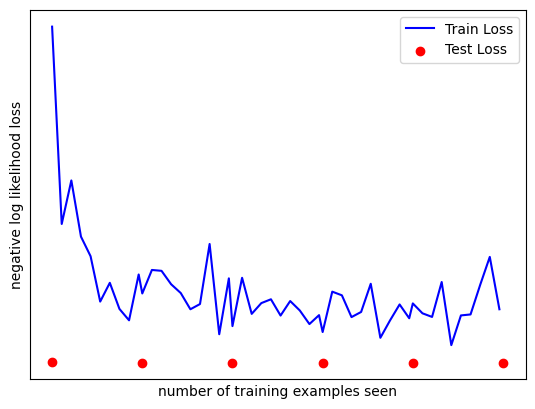

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.xticks([])
plt.yticks([])

In [35]:
with torch.no_grad():
  data, target = example_data.to(device), example_targets.to(device)
  data = data.view(-1, 28*28)
  output = model(data)

  

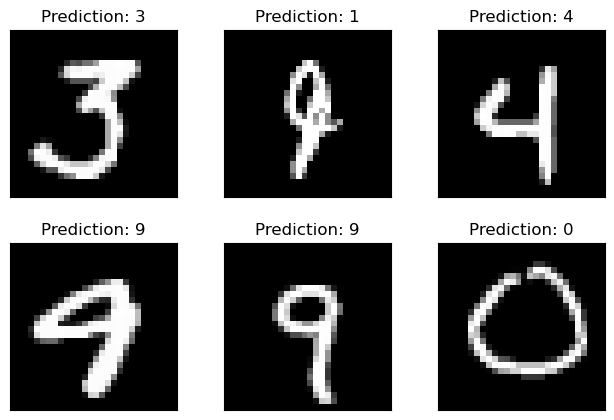

In [36]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [34]:
with torch.no_grad():
  data, target = example_data[3].to(device), example_targets[3].to(device)
  data = data.view(-1, 28*28)
  output = model(data)
  torch.set_printoptions(precision=20, sci_mode=False)

  print(nn.Softmax(dim=1)(output))

tensor([[    0.00000046296707978399,     0.00000000695430113495,
             0.00000569308576814365,     0.00000067588598540169,
             0.01581566594541072845,     0.00010127563291462138,
             0.00000000000000368132,     0.02147671580314636230,
             0.00000275122465609456,     0.96259671449661254883]],
       device='cuda:0')


In [52]:
import json
with open("results/weights.json", "w") as f:
    json_dict = {}
    for key, value in model.state_dict().items():
        json_dict[key] = value.tolist()
    json.dump(json_dict, f)
    # json.dump(model.state_dict(), f)
